In [51]:
import numpy as np
import cv2 as cv
from time import time
import matplotlib.pyplot as plt
from PIL import Image

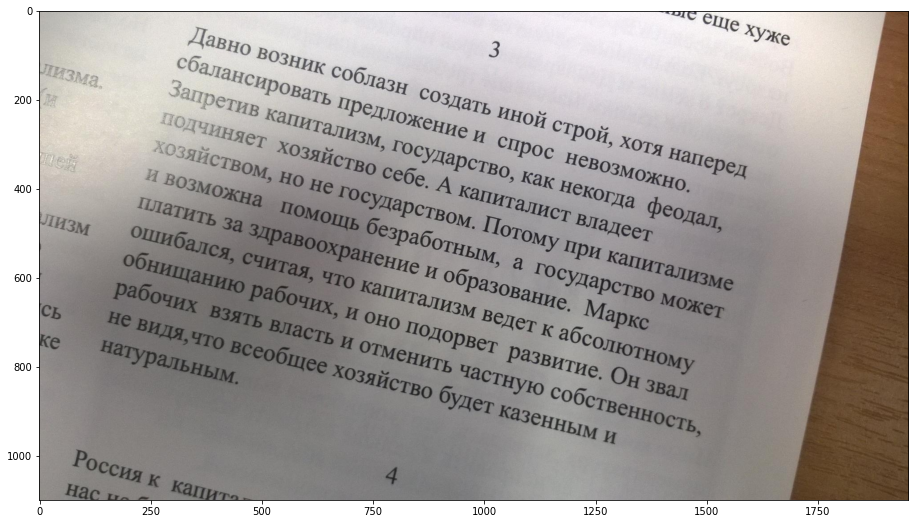

(1100, 1954, 3)

In [8]:
image = cv.cvtColor(cv.imread("1.jpg"),cv.COLOR_BGR2RGB)
plt.figure(figsize = (16, 9))
plt.imshow(image)
plt.show()
image.shape

In [53]:
def round_to_next_power_of_2(x):
    return int(2 ** (np.ceil(np.log2(x))))

def round_to_prev_power_of_2(x):
    return int(2 ** (np.ceil(np.log2(x)) - 1))
    
def preprocess_fht(image, flip=False):
    # убираем шум
    image = np.array(image)
    image = cv.GaussianBlur(image, (3, 3), 0)
    # флипаем т.к. мы срезаем часть картинки и текст может быть на другой стороне
    if flip: 
        image = np.flip(image, axis=1)
    # вычисляем градиенты    
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    grad_x = cv.Sobel(gray, 3, 1, 0, ksize=3)
    grad_y = cv.Sobel(gray, 3, 0, 1, ksize=3)
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)    
    H, W = grad.shape
    W = round_to_prev_power_of_2(W)
    return np.array(grad[:, :W], dtype=np.float32)

def process_strip(image, xmin, xmax):
    H = image.shape[0]
    strip_width = xmax - xmin
    if strip_width == 1:
        return image[:, xmin:xmax]
    fht = np.zeros([H, strip_width])
    left_substrip = process_strip(image, xmin, (xmin + xmax) // 2)
    right_substrip = process_strip(image, (xmin + xmax) // 2, xmax)
    for y in range(H):
        for s in range(strip_width):    
            mid1 = s // 2
            if s % 2:
                mid2 = mid1 + 1
            else:
                mid2 = mid1
            fht[y, s] = left_substrip[y, mid1] + \
                        right_substrip[(y + mid2) % H, mid1]
    return fht

def fht(image, flip=False):
    grad = preprocess_fht(image, flip)
    plt.imshow(grad)
    H, W = grad.shape
    return process_strip(grad, 0, W)

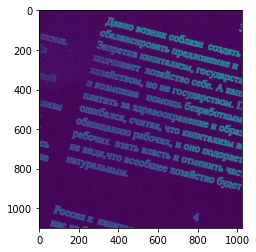

In [29]:
fht_image = fht(image)

(1100, 1024)

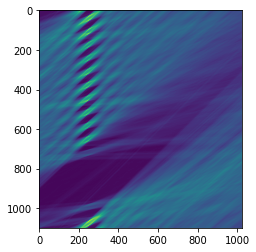

In [10]:
plt.imshow(fht_image)
fht_image.shape

In [13]:
def find_maxvar(fht_image):
    var = np.var(fht_image, axis=0)
    maxvaridx = np.argmax(var)
    return maxvaridx, var[maxvaridx]



def find_angle(fht_image, fht_image_flipped):
    maxvaridx, variance = find_maxvar(fht_image)
    maxvaridx_flipped, variance_flipped = find_maxvar(fht_image_flipped)
    if variance > variance_flipped:
        print('Normal')
        leg = fht_image.shape[1]
        hypotenuse = np.sqrt(maxvaridx ** 2 + leg ** 2)
        sin_a = maxvaridx / hypotenuse
        cos_a = leg / hypotenuse
        return cos_a, -sin_a
    else:
        print('Flipped')
        leg = fht_image_flipped.shape[1]
        hypotenuse = np.sqrt(maxvaridx_flipped ** 2 + leg ** 2)
        sin_a = maxvaridx_flipped / hypotenuse
        cos_a = leg / hypotenuse
        return cos_a, sin_a

Normal
0.9723355630191108 -0.23358842627216922


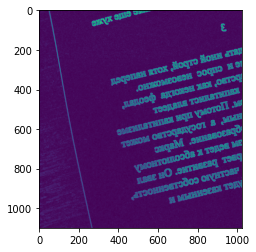

In [30]:
fht_image_flipped = fht(image, flip=True)
co, si = find_angle(fht_image, fht_image_flipped)
print(co, si)

In [54]:
def inverse_transform(x, y, w, h, cos_a, sin_a):
    gamma = min(h / (h * np.abs(cos_a) + w * np.abs(sin_a)), w / (w * np.abs(cos_a) + h * np.abs(sin_a)))
    x *= gamma
    y *= gamma
    x -= w * gamma / 2.
    y -= h * gamma / 2.
    x, y = x * cos_a + y * sin_a, -x * sin_a + y * cos_a
    x += w / 2.
    y += h / 2.
    return x, y


def transform(img, cos_a, sin_a):
    img = np.array(img, dtype='float32')
    H, W, _ = img.shape
    res = np.zeros_like(img)
    for x in range(W):
        for y in range(H):
            x_old, y_old = inverse_transform(x, y, W, H, cos_a, sin_a)        

            x_old = int(np.round(x_old))
            y_old = int(np.round(y_old))
            
            x_old = np.clip(x_old, 0, W - 1)
            y_old = np.clip(y_old, 0, H - 1)
            
            res[y, x, :] = img[y_old, x_old, :]
    return cv.convertScaleAbs(res)

In [32]:
def rotate_image(image):
    fht_image = fht(image)
    fht_image_flipped = fht(image, flip=True)
    cos_a, sin_a = find_angle(fht_image, fht_image_flipped)
    res = transform(image, cos_a, sin_a)
    return res

Normal


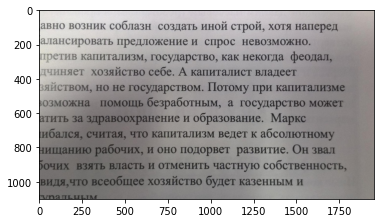

In [33]:
new_image = rotate_image(image)
plt.imshow(new_image)

Измерим время работы

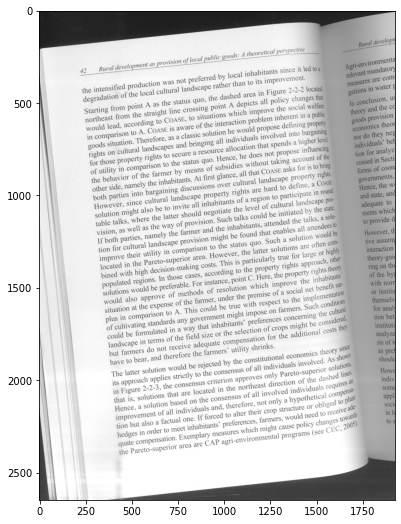

(2648, 1922, 3)

In [46]:
image = cv.cvtColor(cv.imread("7.jpg"),cv.COLOR_BGR2RGB)
plt.figure(figsize = (16, 9))
plt.imshow(image)
plt.show()
image.shape

In [49]:
ws = 2 ** np.arange(1, 11)
grad = preprocess_fht(image)
H = grad.shape[0]
times = []
for w in ws:
    t_0 = time()
    process_strip(grad, 0, w)
    times.append(time() - t_0)

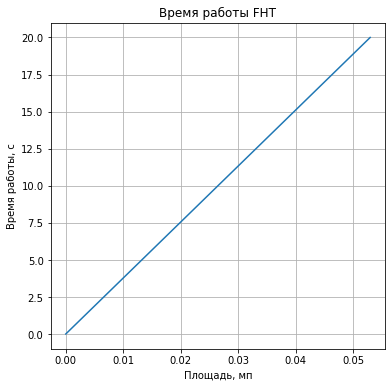

In [50]:
plt.figure(figsize=(6, 6))
plt.title('Время работы FHT')
plt.xlabel('Площадь, мп')
plt.ylabel('Время работы, с')
plt.plot(np.array(times) * H / 1000000, times)
plt.grid()
plt.show()

теоретическая зависимость от размера картинки $N$ есть $N^2 log(N)$, поэтому зависимость от $N^2$ должна быть примерно линейная, что мы и видим на графике

Normal
Flipped
Flipped
Flipped
Flipped
Flipped
Flipped
Normal
Normal


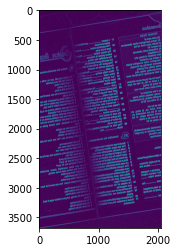

In [55]:
for i in range(1, 10):
    image = cv.cvtColor(cv.imread(f"{i}.jpg"),cv.COLOR_BGR2RGB)
    res = rotate_image(image)
    Image.fromarray(np.array(np.clip(res, 0, 255), dtype=np.uint8)).save(f'{i}_rotated.jpg')

Normal


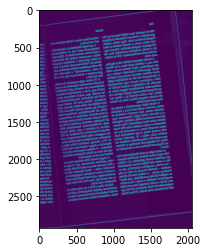

In [56]:
image = cv.cvtColor(cv.imread(f"10.jpg"),cv.COLOR_BGR2RGB)
res = rotate_image(image)
Image.fromarray(np.array(np.clip(res, 0, 255), dtype=np.uint8)).save(f'10_rotated.jpg')